# Model Report

## Setup

### Imports

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from speclet.analysis.arviz_analysis import describe_mcmc
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.posterior_data_manager import PosteriorDataManager
from speclet.project_configuration import arviz_config
from speclet.project_enums import ModelFitMethod

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
set_console_handler_level(logging.INFO)
%config InlineBackend.figure_format = "retina"
arviz_config()

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "hnb-single-lineage-prostate"
FIT_METHOD = "PYMC_NUMPYRO"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
_fit_method = ModelFitMethod(FIT_METHOD)
postman = PosteriorDataManager(
    name=MODEL_NAME,
    fit_method=_fit_method,
    config_path=project_root() / Path(CONFIG_PATH),
    posterior_dir=project_root() / Path(ROOT_CACHE_DIR),
)

## Fit diagnostics

In [6]:
def _plot_rhat_boxplots(pm: PosteriorDataManager) -> None:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(data=pm.posterior_summary, x="var_name", y="r_hat", ax=ax)
    ax.tick_params("x", rotation=90)
    ax.set_ylabel(r"$\widehat{R}$")
    ax.set_ylim(0.999, None)
    plt.show()


def _plot_ess_hist(pm: PosteriorDataManager) -> None:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8, 4)
    )
    sns.histplot(data=pm.posterior_summary, x="ess_bulk", ax=axes[0])
    axes[0].set_title("ESS (bulk)")
    sns.histplot(data=pm.posterior_summary, x="ess_tail", ax=axes[1])
    axes[1].set_title("ESS (tail)")
    for ax in axes.flatten():
        ax.set_xlim(0, None)
    fig.tight_layout()
    plt.show()

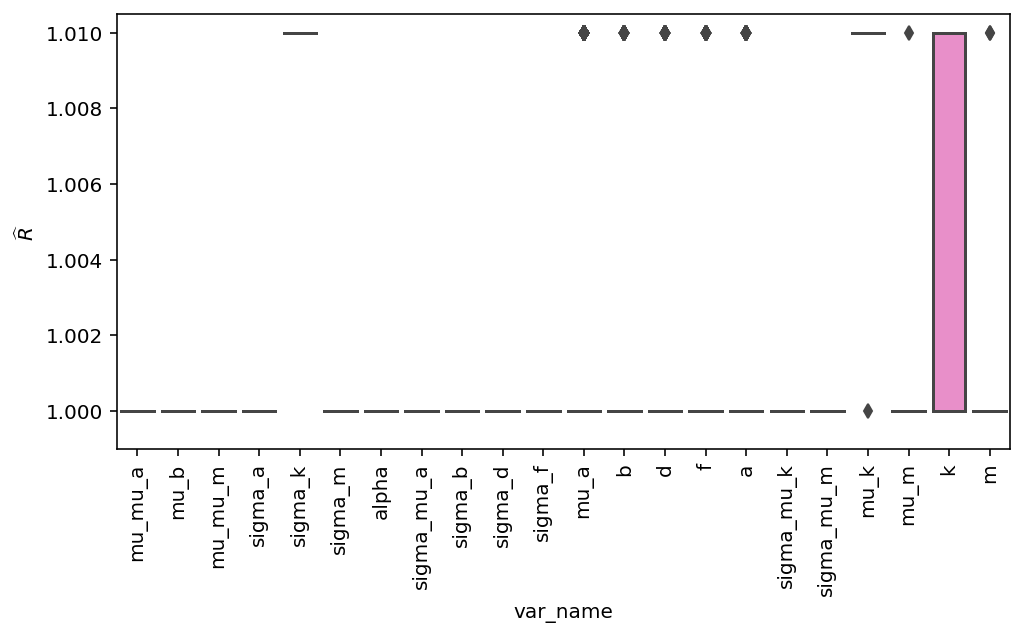

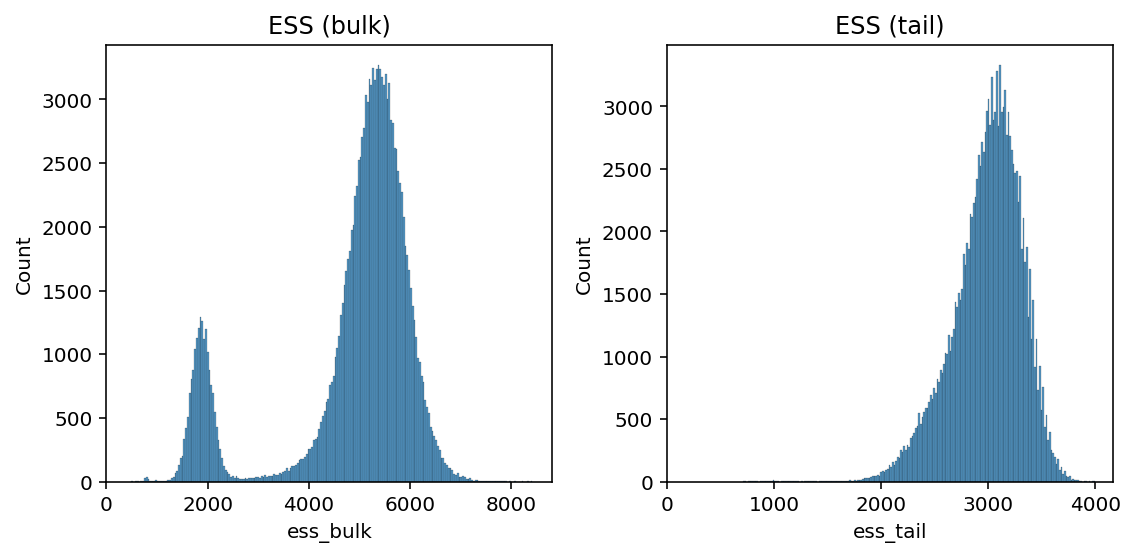

date created: 2022-09-28 10:15
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 0, 0, 0, 0
percent divergences: 0.0, 0.0, 0.0, 0.0
BFMI: 0.637, 0.638, 0.591, 0.584
avg. step size: 0.006, 0.005, 0.006, 0.003
avg. accept prob.: 0.988, 0.991, 0.989, 0.986
avg. tree depth: 9.474, 10.0, 9.0, 10.0


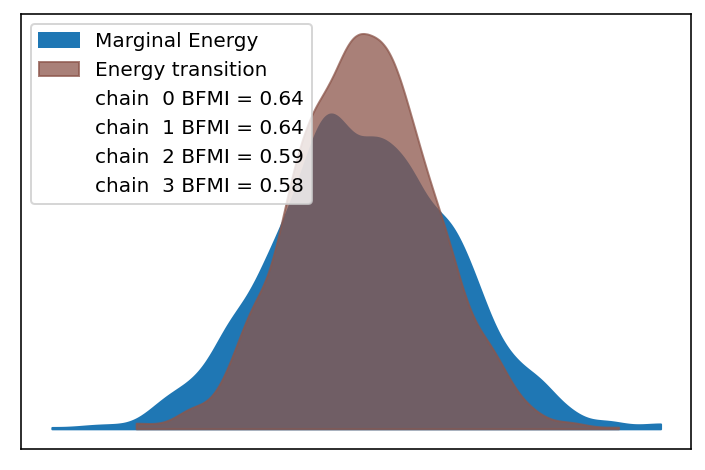

In [7]:
if postman.fit_method in {ModelFitMethod.PYMC_NUMPYRO, ModelFitMethod.PYMC_MCMC}:
    _plot_rhat_boxplots(postman)
    _plot_ess_hist(postman)
    print("=" * 60)
    describe_mcmc(postman.trace)

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-28

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-185.o2.rc.hms.harvard.edu

Git branch: figures

logging   : 0.5.1.2
seaborn   : 0.11.2
matplotlib: 3.5.2

